# An Overview of `astropy.coordinates`:

### Matching catalogs, planning observations, and handling stellar velocities

Astronomers use a wide variety of coordinate systems and formats to represent sky coordinates of celestial objects. For example, you may be familiar with terms like "right ascension" and "declination" or "galactic latitude/longitude," and you may have seen angular coordinate components represented as "0h39m15.9s," "00:39:15.9," or 9.81625º. `astropy.coordinates` provides tools for representing the coordinates of objects and transforming them between different systems. 

In this tutorial, we will explore how the `astropy.coordinates` package and related Astropy functionality can be used to help in planning observations or other exercises focused on large coordinate catalogs. 

You may find it helpful to keep [the Astropy documentation for the coordinates package](http://docs.astropy.org/en/stable/coordinates/index.html) open alongside this tutorial for reference or additional reading. In the text below, you may also see some links that look like ([docs](http://docs.astropy.org/en/stable/coordinates/index.html)). These links will take you to parts of the documentation that are directly relevant to the cells from which they link.

Some of the exercises below are quite complex to complete. For this reason, we provide a possible solution to each one (although there are many possible right answers!). Also note that there is likely not enough time to complete *all* of the exercises in the time we have. So if you're stuck on or disinterested in an exercise, we encourage you to skip over it and come back only if you have time later.

### Preliminary imports

We start by importing some general packages we will need below:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

Note: If the next cell fails, make sure you have installed `astroquery` by running:
```
pip install astroquery
```
in your terminal. If so, you will need to go to "Kernel->Restart" in this notebook after installing.

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.io import fits
from astropy.table import QTable
from astropy.utils.data import download_file

### Preface: representing times

Keeping time can be a messy business, but astropy can make it easier! There are many different units that you may need to use, and many different conventions for representing those times, all implemented in astropy.

First, we import the Time object and represent a time with a Julian date:

In [3]:
from astropy.time import Time

t = Time(2455000, format='jd')

## Alternatively, you could initialize the same time with: 
# t = Time('2009-06-17 12:00')

t

<Time object: scale='utc' format='jd' value=2455000.0>

You can see that by default the time scale is in UTC, the format provided was JD and it is represented in that format to the right. 

You can trivially convert between time formats by calling the name of the time format that you want as an attribute on the time object, like this:  

In [4]:
t.jd, t.iso, t.datetime

(2455000.0, '2009-06-17 12:00:00.000', datetime.datetime(2009, 6, 17, 12, 0))

Let's say you want to convert to a different scale, like from UTC to UT1, just add a `ut1` to the attribute:

In [5]:
t.ut1.iso

'2009-06-17 12:00:00.240'

You can quickly initialize a vector time array of 10 linearly separated times, starting at the current time, like so: 

In [6]:
times = Time.now() + np.linspace(0, 1, 10) * u.day
times

<Time object: scale='utc' format='datetime' value=[datetime.datetime(2024, 2, 29, 19, 8, 51, 686282)
 datetime.datetime(2024, 2, 29, 21, 48, 51, 686282)
 datetime.datetime(2024, 3, 1, 0, 28, 51, 686282)
 datetime.datetime(2024, 3, 1, 3, 8, 51, 686282)
 datetime.datetime(2024, 3, 1, 5, 48, 51, 686282)
 datetime.datetime(2024, 3, 1, 8, 28, 51, 686282)
 datetime.datetime(2024, 3, 1, 11, 8, 51, 686282)
 datetime.datetime(2024, 3, 1, 13, 48, 51, 686282)
 datetime.datetime(2024, 3, 1, 16, 28, 51, 686282)
 datetime.datetime(2024, 3, 1, 19, 8, 51, 686282)]>

## Representing on-sky locations with `astropy.coordinates`

In Astropy, the most common way of representing and working with sky coordinates is to use the `SkyCoord` object. A `SkyCoord` can be created directly from angles or arrays of angles with associated units, as demonstrated below. 

To get started, let's assume that we want to create a `SkyCoord` object for the center of the open cluster NGC 188 so that later we can query and retrieve stars that might be members of the cluster. Let's also assume, for now, that we already know the sky coordinates of the cluster to be (12.11, 85.26) degrees in the ICRS coordinate frame. The ICRS — sometimes referred to as "equitorial" or "J2000" coordinates — is currently the most common astronomical coordinate frame for stellar or extragalactic astronomy, and is the default coordinate frame for `SkyCoord`. We could therefore create a `SkyCoord` object for the center of NGC 188 as:

In [7]:
ngc188_center = SkyCoord(12.11*u.deg, 85.26*u.deg)
ngc188_center

<SkyCoord (ICRS): (ra, dec) in deg
    (12.11, 85.26)>

It is generally recommended to explicitly specify the frame your coordinates are in. In this case, because ICRS is the default, this would be an equivalent way of creating our `SkyCoord` object:

In [8]:
ngc188_center = SkyCoord(12.11*u.deg, 85.26*u.deg, frame='icrs')
ngc188_center

<SkyCoord (ICRS): (ra, dec) in deg
    (12.11, 85.26)>

As we will see below, there are many other supported coordinate frames.

In the above initializations, we passed in `astropy.units.Quantity` objects with angular units to specify the angular components of our sky coordinates. However, `SkyCoord` will also accept string-formatted coordinates either as separate strings for Right Ascension (RA) and Declination (Dec) or a single string:

In [9]:
SkyCoord('00h48m26.4s', '85d15m36s', frame='icrs')

<SkyCoord (ICRS): (ra, dec) in deg
    (12.11, 85.26)>

Some string representations do not explicitly define units, so you would have to specify the units explicitly if they are not included in the string:

In [10]:
SkyCoord('00:48:26.4 85:15:36', unit=(u.hour, u.deg), 
         frame='icrs')

<SkyCoord (ICRS): (ra, dec) in deg
    (12.11, 85.26)>

For more information and examples on initializing `SkyCoord` objects, [see this documentation](http://docs.astropy.org/en/latest/coordinates/skycoord.html).

For the initializations above, we assumed that we already had the coordinate component values ready. If you do not know the coordinate values, and the object you are interested in is in [SESAME](http://cdsweb.u-strasbg.fr/cgi-bin/Sesame), you can also automatically look up and load coordinate values from its name using the `SkyCoord.from_name()` class method<sup>1</sup> ([docs](http://docs.astropy.org/en/latest/coordinates/index.html#convenience-methods)). Note, however, that this requires an internet connection. It is safe to skip this cell if you are not connected to the internet because we already defined it above.

<sub> <sup>1</sup>If you don't know what a class method is, think of it like an alternative constructor for a `SkyCoord` object — calling `SkyCoord.from_name()` with a name gives you a new `SkyCoord` object. For more detailed background on what class methods are and when they're useful, see [this page](https://julien.danjou.info/blog/2013/guide-python-static-class-abstract-methods).</sub>

In [11]:
# NOTE: skip this cell if you do not have an internet connection

ngc188_center = SkyCoord.from_name('NGC 188')
ngc188_center

<SkyCoord (ICRS): (ra, dec) in deg
    (11.798, 85.244)>

The `SkyCoord` object we created has various ways of accessing the information contained within it. All `SkyCoord` objects have attributes that allow you to retrieve the coordinate component data, but the component names will change depending on the coordinate frame of the `SkyCoord` you have. In our case, we have a `SkyCoord` with ICRS coordinates: The component names are therefore lower-case abbreviations of Right Ascension, `.ra`, and Declination, `.dec`:

In [12]:
ngc188_center.ra, ngc188_center.dec

(<Longitude 11.798 deg>, <Latitude 85.244 deg>)

These ``ra`` and ``dec`` attributes return specialized [``Quantity``](http://docs.astropy.org/en/stable/units/index.html) objects (actually, a subclass called [``Angle``](http://docs.astropy.org/en/stable/api/astropy.coordinates.Angle.html), which in turn is subclassed by [``Latitude``](http://docs.astropy.org/en/stable/api/astropy.coordinates.Latitude.html) and [``Longitude``](http://docs.astropy.org/en/stable/api/astropy.coordinates.Longitude.html)).  These objects store angles and provide pretty representations of those angles, as well as some useful attributes to quickly convert to common angle units. For example, in a Jupyter notebook, these objects know how to represent themselves using LaTeX:

In [13]:
ngc188_center.ra

<Longitude 11.798 deg>

In [14]:
ngc188_center.dec

<Latitude 85.244 deg>

We can also retrieve the component values in different units:

In [15]:
ngc188_center.ra.hour, ngc188_center.ra.radian, ngc188_center.ra.degree

(0.7865333333333335, 0.205913945150291, 11.798)

And format the values into strings with specified units ([docs](http://docs.astropy.org/en/latest/coordinates/formatting.html)), for example:

In [16]:
ngc188_center.ra.to_string(unit=u.hourangle, sep=':')

'0:47:11.52'

Now that we have a `SkyCoord` object for the center of NGC 188, we can select sources from the *Gaia* Data Release 2 catalog around this position to try to find stars that might be members of the cluster. To do this, we will use the `astroquery.gaia` module to query the *Gaia* data archive ([docs](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html)).

This requires an internet connection, but if it fails, the catalog file is included in the repository so you can load it locally (i.e., skip the next cell if you do not have an internet connection):

In [17]:
from astroquery.gaia import Gaia

In [18]:
# NOTE: skip this cell if you do not have an internet connection

job = Gaia.cone_search_async(ngc188_center, radius=0.5*u.deg)
table = job.get_results()

# only keep stars brighter than G=19 magnitude
table = table[table['phot_g_mean_mag'] < 19*u.mag]

INFO: Query finished. [astroquery.utils.tap.core]


The above cell may not work if you do not have an internet connection, so we have included the results table along with the notebook:

In [19]:
table = QTable.read('gaia_results.fits')

In [20]:
len(table)

4977

This table now contains about 5000 stars from *Gaia* DR2 around the coordinate position of the center of NGC 188. Let's now construct a `SkyCoord` object with the results table. In the *Gaia* data archive, the ICRS coordinates of a source are given as column names `"ra"` and `"dec"`:

In [21]:
table['ra']

<Quantity [12.12843989, 12.09381253, 12.09832966, ..., 14.15160862,
           12.6107374 ,  9.634002  ] deg>

In [22]:
table['dec']

<Quantity [85.26076889, 85.26522648, 85.25443128, ..., 84.79281259,
           85.75826293, 84.80832667] deg>

Note that, because the *Gaia* archive provides data tables with associated units, and we read this table with the `QTable` object ([docs](http://docs.astropy.org/en/latest/table/mixin_columns.html#quantity-and-qtable)), the above columns are represented as `Quantity` objects with units of degrees. Note also that these columns contain many (>5000!) coordinate values. We can pass these directly in to `SkyCoord` to get a single `SkyCoord` object to represent all of these coordinates:

In [23]:
gaia_coords = SkyCoord(table['ra'], table['dec'])
gaia_coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(12.12843989, 85.26076889), (12.09381253, 85.26522648),
     (12.09832966, 85.25443128), ..., (14.15160862, 84.79281259),
     (12.6107374 , 85.75826293), ( 9.634002  , 84.80832667)]>

### Exercises

Create a `SkyCoord` of the open cluster the Pleiades (either by looking up the coordinates and passing them in, or by using the convenience method we learned about above):

Using only a single method/function call on the `SkyCoord` object representing the center of NGC 188, print a string with the RA/Dec in the form 'HH:MM:SS.S DD:MM:SS.S'. Check your answer against [SIMBAD](http://simbad.u-strasbg.fr/simbad/), which will show you sexagesimal coordinates for the object.

<sub>(Hint: `SkyCoord.to_string()` might be useful.)</sub>

Using a single method/function call on the `SkyCoord` object containing the results of our *Gaia* query, compute the angular separation between each resulting star and the coordinates of the cluster center.

<sub>(Hint: `SkyCoord.separation()` might be useful.)</sub>

---

## More than just sky positions: Including distance information in `SkyCoord`

So far, we have only used `SkyCoord` to represent sky positions (i.e., `ra` and `dec` only). It is sometimes useful to include distance information with the sky coordinates, thereby fully specifying the 3D position of a given source. To pass in distance information, `SkyCoord` accepts a keyword argument `distance`. So, if we knew the distance to NGC 188, we could also pass in a distance (as a `Quantity` object) using this argument:

In [24]:
ngc188_center_3d = SkyCoord(12.11*u.deg, 85.26*u.deg,
                            distance=1.96*u.kpc)

With our results from querying the *Gaia* catalog, we are also given parallax measurements to each star in the catalog. The default way of passing in a distance, as above, is to pass in a `Quantity` with a unit of length. However, `astropy.coordinates` also provides a specialized object, `Distance`, for handling common transformations of different distance representations ([docs](http://docs.astropy.org/en/latest/coordinates/index.html#distance)). Among other things, this class supports passing in a parallax value (but note that the transformation to distance here inverts the parallax, which is not always a good idea!):

In [25]:
Distance(parallax=1*u.mas)

<Distance 1000. pc>

The catalog of stars we queried from *Gaia* contains parallax information, so we can also create a `SkyCoord` object to represent the 3D positions of all of the *Gaia* stars. Here, we sub-select the table to return only stars with positive parallax values:

In [26]:
table_3d = table[table['parallax'] > 0]

gaia_dist = Distance(parallax=table_3d['parallax'])
gaia_coords_3d = SkyCoord(table_3d['ra'], table_3d['dec'],
                          distance=gaia_dist)
gaia_coords_3d

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(12.12843989, 85.26076889, 1835.66340989),
     (12.09381253, 85.26522648, 2184.90012993),
     (12.09832966, 85.25443128, 1109.14781668), ...,
     (14.15160862, 84.79281259, 1159.84996432),
     (12.6107374 , 85.75826293, 2412.31892   ),
     ( 9.634002  , 84.80832667, 1040.65423705)]>

Now that we have 3D position information for both the cluster center, and for the stars we queried from *Gaia*, we can compute the 3D separation (distance) between all of the *Gaia* sources and the cluster center:

In [27]:
sep3d = gaia_coords_3d.separation_3d(ngc188_center_3d)
sep3d

<Distance [124.33660295, 224.90021433, 850.85219575, ..., 800.25800151,
           452.71644735, 919.43018437] pc>

### Exercises

Using the 3D separation values, define a boolean mask to select candidate members of the cluster. Select all stars within 50 pc of the cluster center. How many candidate members of NGC 188 do we have, based on their 3D positions?

---

## Cross-matching and comparing catalogs

Let's recap what we have done so far: We defined a `SkyCoord` object to represent the center of an open cluster (NGC 188), we queried the *Gaia* DR2 catalog to select stars that are close (on the sky) to the center of the cluster, and we used the parallax values from *Gaia* to select stars that are near NGC 188 in 3D position.

Imagine that we now want to cross-match our catalog of candidate members of NGC 188 to another catalog: Here we will cross-match the *Gaia* stars with the 2MASS photometric catalog to retrieve infrared magnitudes for these stars, and then plot a color-magnitude diagram. To do this, we first need to query the 2MASS catalog to retrieve all sources in a region around the center of NGC 188, as we did for *Gaia*. We will once again use `astroquery` to execute this query. This will again require an internet connection, but we have again included the results of this query in a file along with this notebook in case you are not connected to the internet.

To query 2MASS, we will use the `astroquery.vizier` module ([docs](https://astroquery.readthedocs.io/en/latest/vizier/vizier.html)):

In [28]:
from astroquery.vizier import Vizier

In [29]:
# NOTE: skip this cell if you do not have an internet connection

# II/246 is the catalog name for the main 2MASS photometric catalog
v = Vizier(catalog="II/246")  
v.ROW_LIMIT = -1

result = v.query_region(ngc188_center, radius=0.5*u.deg)
tmass_table = result[0]

In [30]:
tmass_table = QTable.read('2MASS_results.fits')

As with the *Gaia* results table, we can now create a single `SkyCoord` object to represent all of the sources returned from our query to the 2MASS catalog. Let's look at the column names in this table by displaying the first few rows:

In [31]:
tmass_table[:3]

RAJ2000,DEJ2000,_2MASS,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,Qflg,Rflg,Bflg,Cflg,Xflg,Aflg
deg,deg,,mag,mag,mag,mag,mag,mag,,,,,,
float64,float64,bytes17,float32,float32,float32,float32,float32,float32,bytes3,bytes3,bytes3,bytes3,uint8,uint8
9.633532,84.808350,00383204+8448300,13.079,0.030,12.742,0.033,12.729,0.035,AAA,222,111,000,0,0
8.562472,84.873627,00341499+8452250,14.459,0.029,14.103,0.041,14.166,0.063,AAA,222,111,000,0,0
8.645318,84.868584,00343487+8452069,10.356,0.026,10.057,0.032,10.000,0.020,AAA,222,111,000,0,0


From looking at the column names, it looks like the two relevant sky coordinate columns are `RAJ2000` for `ra` and `DEJ2000` for `dec`:

In [32]:
tmass_coords = SkyCoord(tmass_table['RAJ2000'], 
                        tmass_table['DEJ2000'])
len(tmass_coords)

5014

We now want to cross-match our *Gaia*-selected candidate members of NGC 188 with this table of photometry from 2MASS. Let's first use the mask we defined above (in the exercise) to select members of NGC 188 based on 3D position:

In [33]:
ngc188_3d_mask = sep3d < 50*u.pc
gaia_ngc188_members = gaia_coords_3d[ngc188_3d_mask]
gaia_ngc188_members_table = table_3d[ngc188_3d_mask]

Now we can use the ``SkyCoord.match_to_catalog_sky`` method to match the two catalogs ([docs](http://docs.astropy.org/en/latest/coordinates/matchsep.html#astropy-coordinates-matching)). Note that order matters: Here we are matching 2MASS to *Gaia* because we ultimately want to make a color-magnitude diagram using the 2MASS photometry. `SkyCoord.match_to_catalog_sky` returns three objects: first, the indices into `gaia_ngc188_members` that get the closest matches in `tmass_coords`, second, the angular separation between each `tmass_coords` coordinate and the closest source in `gaia_ngc188_members`, and finally, the 3D distance between each `tmass_coords` coordinate and the closest source in `gaia_ngc188_members`. Here, the 3D distances will not be useful because the 2MASS coordinates do not have associated distance information:

In [34]:
idx_tmass, d2d_tmass, d3d_tmass = tmass_coords.match_to_catalog_sky(gaia_ngc188_members)

Let's now look at the distribution of separations for all of the cross-matched sources:

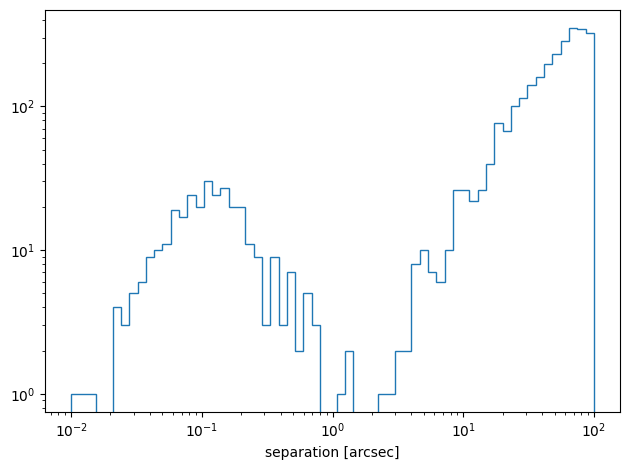

In [35]:
plt.hist(d2d_tmass.arcsec, histtype='step', 
         bins=np.logspace(-2, 2., 64))
plt.xlabel('separation [arcsec]')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

From this, it looks like the sources that actually match to our *Gaia* NGC 188 members are all within about 2 arcseconds, so that is promising! How many of the 2MASS sources matched to one of our NGC 188 candidate members?

In [36]:
(d2d_tmass < 2*u.arcsec).sum()

309

That is a large fraction of the 321 members we identified. Missing sources may be too faint for 2MASS to detect, so we do not expect all of the *Gaia* sources to be in 2MASS. With our cross-match done, we can now make 2MASS+Gaia color-magnitude diagrams of our candidate NGC 188 members:

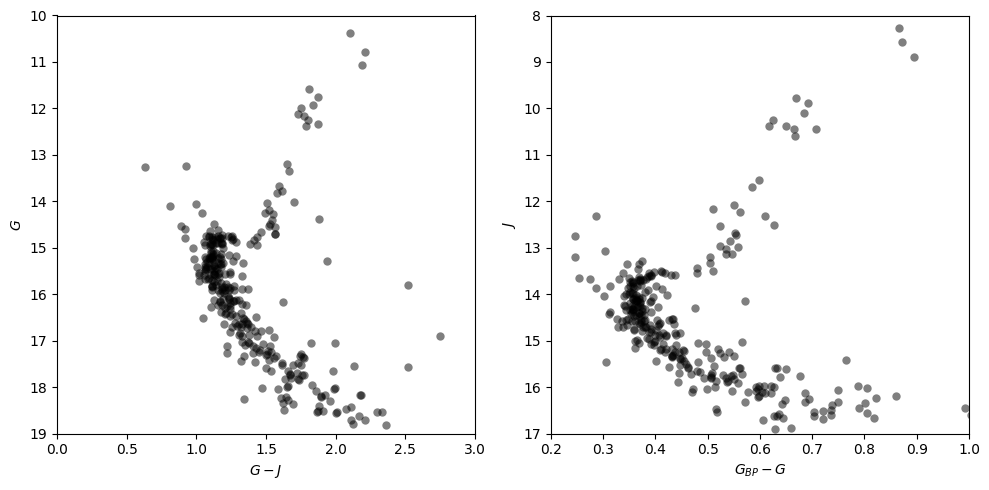

In [37]:
Jmag = tmass_table['Jmag'][d2d_tmass < 2*u.arcsec]
Gmag = gaia_ngc188_members_table['phot_g_mean_mag'][idx_tmass[d2d_tmass < 2*u.arcsec]]
Bmag = gaia_ngc188_members_table['phot_bp_mean_mag'][idx_tmass[d2d_tmass < 2*u.arcsec]]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(Gmag - Jmag, Gmag, 
           marker='o', color='k', 
           linewidth=0, alpha=0.5)
ax.set_xlabel('$G - J$')
ax.set_ylabel('$G$')
ax.set_xlim(0, 3)
ax.set_ylim(19, 10) # backwards because magnitudes!

ax = axes[1]
ax.scatter(Bmag - Gmag, Jmag, 
           marker='o', color='k', 
           linewidth=0, alpha=0.5)
ax.set_xlabel('$G_{BP} - G$')
ax.set_ylabel('$J$')
ax.set_xlim(0.2, 1)
ax.set_ylim(17, 8) # backwards because magnitudes!

fig.tight_layout()

Those both look like color-magnitude diagrams of a main sequence + red giant branch of an intermediate-age stellar cluster, so it looks like our selection and cross-matching has worked!

For more on what matching options are available, check out the [separation and matching section of the Astropy documentation](https://astropy.readthedocs.io/en/stable/coordinates/matchsep.html). Or for more on what you can do with `SkyCoord`, see [its API documentation](http://astropy.readthedocs.org/en/stable/api/astropy.coordinates.SkyCoord.html).

### Exercises

*Note: skip this exercise if you do not have an internet connection.*

Using the coordinates of the center of the Pleiades you defined in the previous set of exercises, download a catalog of 2MASS sources within 1 degree of the center of the Pleiades. Make a color-magnitude diagram of J-H vs. J for all sources. Can you see the main sequence corresponding to the Pleiades?

*Note: skip this exercise if you do not have an internet connection.*

Again using the coordinates of the center of the Pleiades, now download all *Gaia* sources within 1 degree of the center of the Pleiades. Cross-match the 2MASS and *Gaia* sources, and make a G-J vs. G color-magnitude diagram of all sources within 200 parsecs of the Sun.

---

## Transforming between coordinate systems and planning observations

Imagine that we found something exciting in our exploration of the data for NGC 188, and we would like to follow-up with our own observations of a given sources. `astropy.coordinates` provides tools to assist in planning observations, especially from ground-based observatories, as we will see below. 

### Introducting frame transformations

To understand the code in this section, it may help to read over the [overview of the astropy coordinates scheme](http://astropy.readthedocs.org/en/stable/coordinates/index.html#overview-of-astropy-coordinates-concepts).  The key concept to understand is that all coordinates in Astropy are in particular reference "frames," and we can transform between a specific `SkyCoord` object in one frame to another. For example, we can transform our previously-defined center of NGC 188 from ICRS to another coordinate frame, like Galactic coordinates. In `astropy.coordinates`, this is typically done using the `.transform_to()` method:

In [38]:
ngc188_center.transform_to('galactic')

<SkyCoord (Galactic): (l, b) in deg
    (122.8367566, 22.37303701)>

This method either takes a string name of a coordinate frame, or an instance of a coordinate frame object itself. For example, the class representing the Galactic frame is:

In [39]:
from astropy.coordinates import Galactic
ngc188_center.transform_to(Galactic())

<SkyCoord (Galactic): (l, b) in deg
    (122.8367566, 22.37303701)>

For coordinate frames that do not require additional parameters, the transformations can also be accessed by attributes of the `SkyCoord` object. Another way to transform to the Galactic frame, then, is to do:

In [40]:
ngc188_center.galactic

<SkyCoord (Galactic): (l, b) in deg
    (122.8367566, 22.37303701)>

Note that changing frames also changes some of the attributes of the object, most often the names of the component attributes. Recall that for the ICRS frame the components were `ra` and `dec`. For the Galactic frame, the corresponding longitude and latitude are named `l` and `b`:

In [41]:
ngc188_gal = ngc188_center.galactic
ngc188_gal.l, ngc188_gal.b

(<Longitude 122.8367566 deg>, <Latitude 22.37303701 deg>)

Note that the names `.ra` and `.dec` will therefore *not* work on this transformed `SkyCoord`:

In [42]:
# THIS SHOULD ERROR:
ngc188_gal.ra

AttributeError: 'SkyCoord' object has no attribute 'ra'

### Using frame transformations to get to AltAz

To determine whether a target is observable from a given observatory on Earth, we need to convert our coordinate to a frame local to an on-earth observer. The most common choice for such a frame is horizontal coordinates, or "AltAz" coordinates. The `AltAz` coordinate frame requires a few extra pieces of information to define: a location on Earth, and the time of observation. These are handled with the `EarthLocation` and `Time` objects, respectively:

In [43]:
from astropy.coordinates import EarthLocation
from astropy.time import Time

Let's assume we will be observing at Kitt Peak in a few weeks. We can retrieve the Earth location of Kitt Peak using the `EarthLocation.of_site` method:

In [44]:
observing_location = EarthLocation.of_site('Kitt Peak')
# List of all locations can be viewed using
# EarthLocation.get_site_names()

And let's pretend our observing run starts on Jan 20 this year:

In [45]:
observing_time = Time('2020-01-20 1:00')  # 1am UTC=6pm AZ mountain time

Now we use these to create an `AltAz` frame object. Note that this frame has even more information about the atmosphere, which can be used to correct for atmospheric refraction. Here we leave that alone, because the default is to ignore this effect (by setting the air pressure to 0).

In [46]:
from astropy.coordinates import AltAz

altaz = AltAz(location=observing_location, obstime=observing_time)
altaz

<AltAz Frame (obstime=2020-01-20 01:00:00.000, location=(-1994502.60430614, -5037538.54232911, 3358104.99690298) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron)>

Now we can transform our ICRS `SkyCoord` to `AltAz` to get the location in the sky over Kitt Peak at the requested time:

In [47]:
ngc188_center.transform_to(altaz)

<SkyCoord (AltAz: obstime=2020-01-20 01:00:00.000, location=(-1994502.60430614, -5037538.54232911, 3358104.99690298) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (359.00085221, 36.5327235)>

Alright, the cluster NGC 188 is up at 6PM local time at Kitt Peak, but that is pretty early to be observing. We could try various times one at a time to see if the airmass is at a darker time, but we can do better — we can make an airmass plot for the whole night:

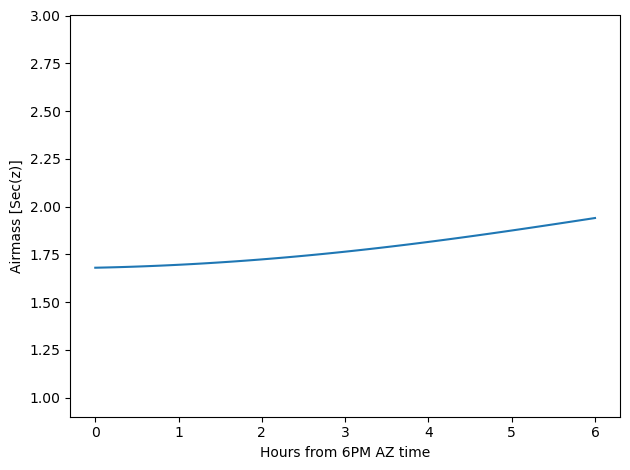

In [48]:
# this gives a Time object with an *array* of times
delta_hours = np.linspace(0, 6, 100)*u.hour
full_night_times = observing_time + delta_hours
full_night_altaz = AltAz(location=observing_location, obstime=full_night_times)
full_night_altaz_coords = ngc188_center.transform_to(full_night_altaz)

plt.plot(delta_hours, full_night_altaz_coords.secz)
plt.xlabel('Hours from 6PM AZ time')
plt.ylabel('Airmass [Sec(z)]')
plt.ylim(0.9, 3)
plt.tight_layout()

It looks like our source is observable at relatively high airmass for most of the night, but the minimum airmass is at the start of the night. When can we start observing with proper dark skies? Astropy also provides a ``get_sun`` function that can be used to check the sky position of the sun to check, for example, when we are in 18-degree twilight:

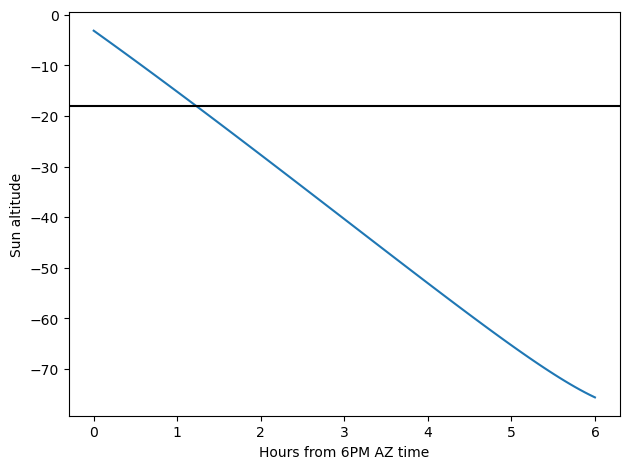

In [49]:
from astropy.coordinates import get_sun

full_night_sun_coos = get_sun(full_night_times).transform_to(full_night_altaz)
plt.plot(delta_hours, full_night_sun_coos.alt.deg)
plt.axhline(-18, color='k')
plt.xlabel('Hours from 6PM AZ time')
plt.ylabel('Sun altitude')
plt.tight_layout()

It looks like it's just below -18 degrees a little after 7PM local time, so we can start observing our target then!

### Exercises

Try converting the NGC 188 center coordinates to an equatorial frame at some other equinox a while in the past (e.g., J1900). Do you see the precession of the equinoxes?

<sub>Hint: To see a diagram of the supported frames, see [here](http://docs.astropy.org/en/stable/coordinates/#module-astropy.coordinates). `FK5` has a parameter called 'equinox' — that looks promising!</sub>

What time is Sunset on our observing night? Try solving for the time at which the Sun's altitude is closest to 0 (i.e., do not just eyeball the plot, like we did above).

---

## More than just sky positions: Including velocity information in `SkyCoord`

As we have seen above, the `SkyCoord` object can store scalars or arrays of positional coordinate information, can transform between different coordinate frames, and can cross-match sets of coordinates. But wait, there's more! `astropy.coordinates` also supports representing and transforming *velocity* information along with positions ([docs](http://docs.astropy.org/en/latest/coordinates/velocities.html)).

### Passing velocity data in to `SkyCoord`

Velocity data is passed in to `SkyCoord` in a very similar way to the positional coordinates demonstrated above. However, velocity data must be passed in using keyword arguments, meaning that you must write out the velocity component names, for example:

In [50]:
SkyCoord(ra=10*u.deg, 
         dec=20*u.deg,
         pm_ra_cosdec=1*u.mas/u.yr,
         pm_dec=2*u.mas/u.yr)

<SkyCoord (ICRS): (ra, dec) in deg
    (10., 20.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (1., 2.)>

In the above, we create a `SkyCoord` instance with sky position and proper motion data. The proper motion component names for ICRS coordinates are, by default, `pm_ra_cosdec` and `pm_dec` ("pm" for "proper motion"). You can also specify radial velocity data via the `radial_velocity` argument, for example:

In [51]:
velocity_coord = SkyCoord(ra=10*u.deg, 
                          dec=20*u.deg,
                          pm_ra_cosdec=1*u.mas/u.yr,
                          pm_dec=2*u.mas/u.yr,
                          radial_velocity=100*u.km/u.s)
velocity_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (10., 20.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (1., 2., 100.)>

A `SkyCoord` object with velocity data can be transformed to other frames just like the objects we are used to from above:

In [52]:
velocity_coord.transform_to('galactic')

<SkyCoord (Galactic): (l, b) in deg
    (119.26936774, -42.79039286)
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    (1.11917063, 1.93583499, 100.)>

An important caveat, however, is that some reference frames require knowing distance in order to transform all velocity components — something we did not specify in the `velocity_coord` definition above:

In [53]:
# THIS SHOULD ERROR:
velocity_coord.transform_to(altaz)

UnitConversionError: need a distance to retrieve a cartesian representation when both radial velocity and proper motion are present, since otherwise the units cannot match.

### Evolving coordinate positions between epochs

For nearby or fast-moving stars, a star's position could change appreciably between two well-spaced observations of the source. For such cases, it might be necessary to evolve the position of the star using the proper motion or velocity of the star in order to accurately predict its position at a new time. Below, we will demonstrate this using data from the Digitized Sky Survey (DSS; digital scans of photographic plates observed in the 1950s) and data from the *Gaia* mission (at epoch J2015.5).

The star HD 219829 has a very large proper motion, close to 0.5 arcsec/year. Between the DSS and *Gaia*, we therefore expect that the position of the star has changed by about 0.5 arcmin; let's see if this is the case! To start, we will query the *Gaia* catalog to retrieve data for this star (but skip the cell below if you do not have an internet connection):

In [38]:
# NOTE: skip this cell if you do not have an internet connection

hd219829_coord_2015 = SkyCoord(349.72896715675495, 5.405115847648341, unit=u.deg)
hd219829_gaia_table = Gaia.query_object_async(hd219829_coord_2015, radius=2*u.arcsec)
hd219829_gaia_table = QTable(hd219829_gaia_table)  # ignore any warnings output by this!

hd219829_coord = SkyCoord(ra=hd219829_gaia_table['ra'],
                          dec=hd219829_gaia_table['dec'],
                          distance=Distance(parallax=hd219829_gaia_table['parallax']),
                          pm_ra_cosdec=hd219829_gaia_table['pmra'],
                          pm_dec=hd219829_gaia_table['pmdec'],
                          radial_velocity=hd219829_gaia_table['radial_velocity'],
                          obstime=Time('J2015.5'))

INFO: Query finished. [astroquery.utils.tap.core]


In [39]:
hd219829_coord = SkyCoord(ra=349.72896716*u.deg, 
                          dec=5.40511585*u.deg,
                          distance=34.47896*u.pc,
                          pm_ra_cosdec=483.41659*u.mas/u.yr,
                          pm_dec=-114.86339*u.mas/u.yr,
                          obstime=Time('J2015.5'))

Note above that we specify a new keyword argument, `obstime`, to `SkyCoord`: This is the observation time of the coordinates, and will be important later when we evolve the position of this star using its proper motion.

We now have the position and proper motion for HD 219829. Let's now query the DSS to retrieve a FITS image of the field around this star, using the STSCI DSS image cutout service. Again, skip the cell below if you do not have an internet connection:

In [46]:
# NOTE: skip this cell if you do not have an internet connection

dss_cutout_filename = download_file(f"http://archive.stsci.edu/cgi-bin/dss_search?"
                                    f"f=FITS&ra={hd219829_coord.ra.degree}&dec={hd219829_coord.dec.degree}"
                                    f"&width=400&height=400")  # width/height in arcmin

In [47]:
dss_cutout_filename = 'dss_hd219829.fits'

We can now load the FITS image of the cutout and use `astropy.visualization` to display the image using its World Coordinate System (WCS) info ([docs](http://docs.astropy.org/en/latest/visualization/wcsaxes/index.html)). By passing in the WCS information (included in the FITS cutout header), we can over-plot a marker for the *Gaia*-measured sky position of HD 219829:

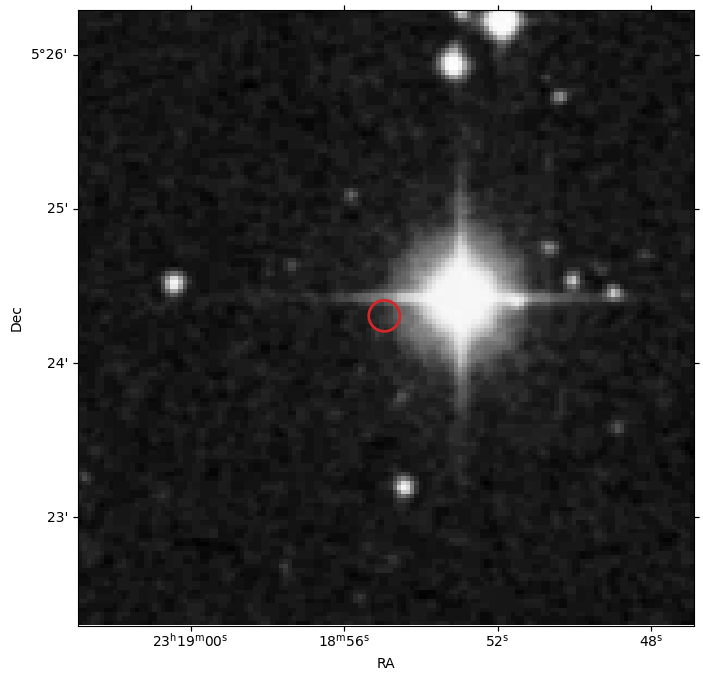

In [50]:
from astropy.wcs import WCS

hdu = fits.open(dss_cutout_filename)[0]
wcs = WCS(hdu.header)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                       subplot_kw=dict(projection=wcs))
ax.imshow(hdu.data, origin='lower', cmap='Greys_r')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_autoscale_on(False)

ax.scatter(hd219829_coord.ra.degree,
           hd219829_coord.dec.degree,
           s=500,
           transform=ax.get_transform('world'),
           facecolor='none', linewidth=2, color='tab:red')

The bright star (as observed by DSS) is our target, and the red circle is where *Gaia* observed this star — it has moved! But, we can account for this, and predict the position of the star at around the time the DSS plate was observed (let's assume it was exactly 1950 — this is not strictly correct, but should be good enough).

To account for the proper motion of the source and evolve the position to a new time, we can use the `SkyCoord.apply_space_motion()` method ([docs](http://docs.astropy.org/en/latest/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord.apply_space_motion)):

In [51]:
hd219829_coord_1950 = hd219829_coord.apply_space_motion(new_obstime=Time('J1950'))  # ignore the ErfaWarning

/Users/papa/miniforge3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


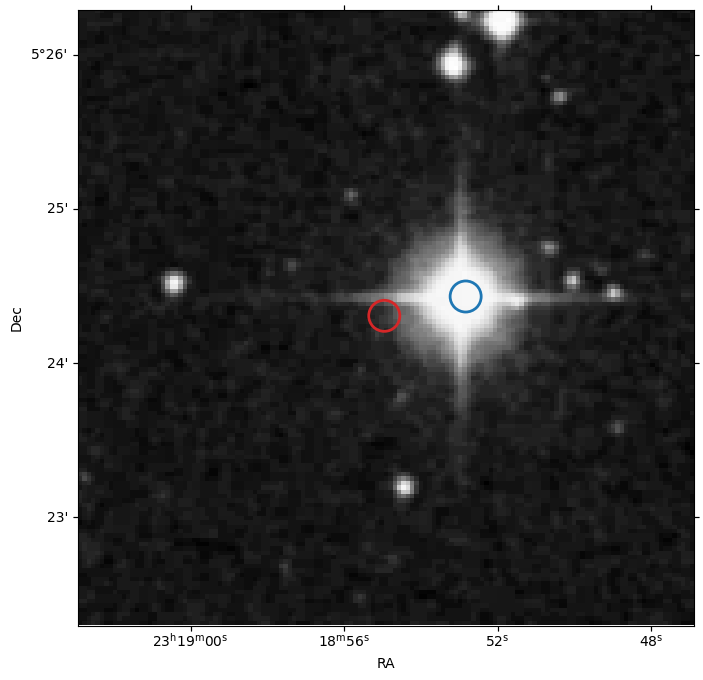

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                       subplot_kw=dict(projection=wcs))
ax.imshow(hdu.data, origin='lower', cmap='Greys_r')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_autoscale_on(False)

ax.scatter(hd219829_coord.ra.degree,
           hd219829_coord.dec.degree,
           s=500,
           transform=ax.get_transform('world'),
           facecolor='none', linewidth=2, color='tab:red')

# Plot the predicted (past) position:
ax.scatter(hd219829_coord_1950.ra.degree,
           hd219829_coord_1950.dec.degree,
           s=500,
           transform=ax.get_transform('world'),
           facecolor='none', linewidth=2, color='tab:blue')

The predicted position of the star from 1950 is much closer to where the star is in the DSS image. Success!

### Exercises

The *Gaia* data table we downloaded for sources around NGC 188 also contains proper motion information. Do any of the sources in the field around NGC 188 have large enough proper motions that we might detect a difference between the DSS position of a star and the *Gaia* position? How many stars have an apparent change in position > 5 arcsec over 60 years?

Download a DSS image for the region around the fastest-moving star in the NGC 188 field. By accounting for the proper motion, can you predict where the star is in the DSS image using only the *Gaia* position and proper motion?

## Wrap-up

This tutorial covers a lot of material, but `astropy.coordinates` has even more functionality that we were unable to cover in this workshop. For documentation on other features of `astropy.coordinates`, check out [the astropy.coordinates section of the Astropy documentation](http://astropy.readthedocs.org/en/stable/coordinates/index.html).

You might also be interested in [the astroplan affiliated package](http://astroplan.readthedocs.org/), which uses the `astropy.coordinates` to do more advanced versions of the observation planning tasks briefly covered above.